In this demo we load one `dispersion.nc` file and explore how to visualize the data within the file.

#### Accessing the File

We use the forecast for March 4, 2021 where the weather forecast is initiated at 00:00:00 UTC and the smoke forecast is initialized at 08:00:00 UTC. You can download this file by navigating to the URL below.

In [1]:
forecast_id = "BSC00CA12-01"
yyyymmdd = "20210304"
init_time = "08"

url = (
    f"https://firesmoke.ca/forecasts/{forecast_id}/{yyyymmdd}{init_time}/dispersion.nc"
)

print(f"Download this file from URL: {url}")

import urllib.request
urllib.request.urlretrieve(url, "dispersion.nc")


Download this file from URL: https://firesmoke.ca/forecasts/BSC00CA12-01/2021030408/dispersion.nc


('dispersion.nc', <http.client.HTTPMessage at 0x1e3530b0990>)

##### Opening the File

We use xarray to open the NetCDF file and preview it.

In [2]:
import xarray as xr

ds = xr.open_dataset("dispersion.nc")

ds

<xarray.Dataset> Size: 81MB
Dimensions:  (TSTEP: 51, VAR: 1, DATE-TIME: 2, LAY: 1, ROW: 381, COL: 1041)
Dimensions without coordinates: TSTEP, VAR, DATE-TIME, LAY, ROW, COL
Data variables:
    TFLAG    (TSTEP, VAR, DATE-TIME) int32 408B ...
    PM25     (TSTEP, LAY, ROW, COL) float32 81MB ...
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2021063
    CTIME:          101914
    WDATE:          2021063
    ...             ...
    VGLVLS:         [10.  0.]
    GDNAM:          HYSPLIT CONC    
    UPNAM:          hysplit2netCDF  
    VAR-LIST:       PM25            
    FILEDESC:       Hysplit Concentration Model Output                       ...
    HISTORY:

#### Using the Data

##### Accessing Arrays

The data we are interested in is the PM2.5 values. Let's use `xarray` to preview the `PM25` variable in our file.

In [3]:
ds["PM25"]

<xarray.DataArray 'PM25' (TSTEP: 51, LAY: 1, ROW: 381, COL: 1041)> Size: 81MB
[20227671 values with dtype=float32]
Dimensions without coordinates: TSTEP, LAY, ROW, COL
Attributes:
    long_name:  PM25            
    units:      ug/m^3          
    var_desc:   PM25                                                         ...

The dimensions of the `PM25` data array are composed of `TSTEP`, `LAY`, `ROW`, and `COL`. We do not need the `LAY` dimension, so let's use `numpy` to remove it.

In [4]:
import numpy as np

ds_pm25_vals = ds["PM25"].values # <1>
print(f'The shape of the data contained in our files is: {np.shape(ds_pm25_vals)}')

ds_pm25_vals = np.squeeze(ds_pm25_vals) # <2>
print(f'After squeezing, the shape is: {np.shape(ds_pm25_vals)}')

The shape of the data contained in our files is: (51, 1, 381, 1041)
After squeezing, the shape is: (51, 381, 1041)


1. Use .values to get the four dimensional array.
2. Use `np.squeeze` to drop the LAY axis

##### Visualize Array in `matplotlib`

Now that we squeezed away the `LAY` dimension, we can index time step 15 and use `matplotlib` to visualize the timestep

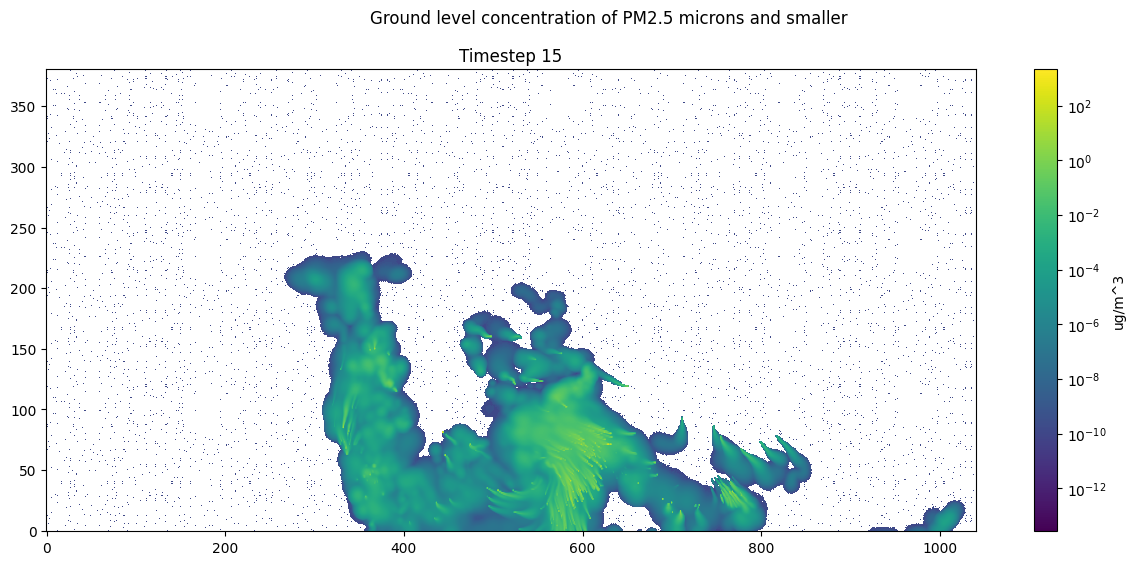

In [5]:
import matplotlib.pyplot as plt

tstep = 15
smoke_at_tstep = ds_pm25_vals[tstep, :, :]

my_fig, my_plt = plt.subplots(figsize=(15, 6))

my_norm = "log" # <1>
my_aspect = 'auto' # <2>
my_origin = 'lower' # <3>
my_cmap = 'viridis' # <4>
 
plot = my_plt.imshow(smoke_at_tstep, norm=my_norm, aspect=my_aspect, origin=my_origin, cmap=my_cmap) # <5>

my_fig.colorbar(plot, location='right', label='ug/m^3') # <6>

my_fig.suptitle('Ground level concentration of PM2.5 microns and smaller') # <7>

my_plt.set_title(f'Timestep {tstep}') # <8>

plt.show() # <9>

1. Color PM25 values on a log scale, since values are small.
2. Ensure the aspect ratio of our plot fits all data, `matplotlib` can do this automatically.
3. Tell `matplotlib` our origin is the lower-left corner.
4. Select a colormap for our plot and draw the color bar on the right.
5. Create our plot using `imshow`.
6. Add a colorbar to our figure, based on the plot we just made above.
7. Set title of our figure.
8. Set title of our plot as the timestamp of our data.
9. Show the resulting visualization.

Notice there are no axis labels or metadata presented here. Next we will show how to use the metadata in `dispersion.nc` so the data is actually interpretable.

#### Incorporating Metadata to Visualization via Coordinates

###### Latitude and Longitude Coordinates

`dispersion.nc` includes attributes to generate the latitude and longitude values on the grid defined by `NCOLS` and `NROWS`. We use this grid to match each data point in the `PM25` variable to a lat/lon coordinate.

In [6]:
xorig = ds.XORIG
yorig = ds.YORIG
xcell = ds.XCELL
ycell = ds.YCELL
ncols = ds.NCOLS
nrows = ds.NROWS

longitude = np.linspace(xorig, xorig + xcell * (ncols - 1), ncols)
latitude = np.linspace(yorig, yorig + ycell * (nrows - 1), nrows)

print("Size of longitude & latitude arrays:")
print(f'np.size(longitude) = {np.size(longitude)}')
print(f'np.size(latitude) = {np.size(latitude)}\n')
print("Min & Max of longitude and latitude arrays:")
print(f'longitude: min = {np.min(longitude)}, max = {np.max(longitude)}')
print(f'latitude: min = {np.min(latitude)}, max = {np.max(latitude)}')

Size of longitude & latitude arrays:
np.size(longitude) = 1041
np.size(latitude) = 381

Min & Max of longitude and latitude arrays:
longitude: min = -156.0, max = -51.999998450279236
latitude: min = 32.0, max = 70.00000056624413


`xarray` allows us to create coordinates, which maps variable values to a value of our choice. In this case, we create coordinates mapping PM25 values to a latitude and longitude value.

In [7]:
ds.coords['lat'] = ('ROW', latitude) # <1>
ds.coords['lon'] = ('COL', longitude)

ds = ds.swap_dims({'COL': 'lon', 'ROW': 'lat'})

ds

<xarray.Dataset> Size: 81MB
Dimensions:  (TSTEP: 51, VAR: 1, DATE-TIME: 2, LAY: 1, lat: 381, lon: 1041)
Coordinates:
  * lat      (lat) float64 3kB 32.0 32.1 32.2 32.3 32.4 ... 69.7 69.8 69.9 70.0
  * lon      (lon) float64 8kB -156.0 -155.9 -155.8 -155.7 ... -52.2 -52.1 -52.0
Dimensions without coordinates: TSTEP, VAR, DATE-TIME, LAY
Data variables:
    TFLAG    (TSTEP, VAR, DATE-TIME) int32 408B ...
    PM25     (TSTEP, LAY, lat, lon) float32 81MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2021063
    CTIME:          101914
    WDATE:          2021063
    ...             ...
    VGLVLS:         [10.  0.]
    GDNAM:          HYSPLIT CONC    
    UPNAM:          hysplit2netCDF  
    VAR-LIST:       PM25            
    FILEDESC:       Hysplit Concentration Model Output                       ...
    HISTORY:

1. Create coordinates for latitude and longitude.
2. Replace `COL` and `ROW` dimensions with newly calculated longitude and latitude coordinates.

Now let's move on to incorporating time stamp metadata.

##### Time Coordinates

Recall, there is a `TFLAG` variable in `dispersion.nc`.

In [8]:
ds['TFLAG']

<xarray.DataArray 'TFLAG' (TSTEP: 51, VAR: 1, DATE-TIME: 2)> Size: 408B
[102 values with dtype=int32]
Dimensions without coordinates: TSTEP, VAR, DATE-TIME
Attributes:
    units:      <YYYYDDD,HHMMSS>
    long_name:  TFLAG           
    var_desc:   Timestep-valid flags:  (1) YYYYDDD or (2) HHMMSS             ...

The earliest and latest `TFLAG`s look like the following:

In [9]:
print(f"Earliest available TFLAG is {ds['TFLAG'].values[0][0]}")
print(f"Latest available TFLAG is {ds['TFLAG'].values[-1][0]}")

Earliest available TFLAG is [2021063   90000]
Latest available TFLAG is [2021065  110000]


This time flags require processing to be immediately legible. Let's write a function to process the time flag accordingly. We use the `datetime` library.

In [10]:
import datetime

def parse_tflag(tflag):
    """
    Return the tflag as a datetime object
    :param list tflag: a list of two int32, the 1st representing date and 2nd representing time
    """
    date = int(tflag[0]) # <1>
    year = date // 1000 # <2>
    day_of_year = date % 1000 # <3>

    final_date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=day_of_year - 1) # <4>

    time = int(tflag[1]) # <5>
    hours = time // 10000 # <6>
    minutes = (time % 10000) // 100 # <7>
    seconds = time % 100  # <8>

    full_datetime = datetime.datetime(year, final_date.month, final_date.day, hours, minutes, seconds) # <9>
    return full_datetime

1. Obtain year and day of year from `tflag[0]` (date).
2. Extract the year from the first 4 digits of `tflag[0]`.
3. Extract the day of the year from the last 3 digits of `tflag[0]`.
4. Create a `datetime` object representing the date.
5. Obtain hour, minutes, and seconds from `tflag[1]` (time).
6. Extract hours from the first 2 digits of `tflag[1]`.
7. Extract minutes from the 3rd and 4th digits of `tflag[1]`.
8. Extract seconds from the last 2 digits of `tflag[1]`.
9. Create the final `datetime` object with the extracted date and time components.

Now we have datetime objects to represent the timeflag in a more legible and usable format.

In [11]:
print(f"Earliest available TFLAG is {parse_tflag(ds['TFLAG'].values[0][0])}")
print(f"Latest available TFLAG is {parse_tflag(ds['TFLAG'].values[-1][0])}")

Earliest available TFLAG is 2021-03-04 09:00:00
Latest available TFLAG is 2021-03-06 11:00:00


##### Visualize Array in `matplotlib`

Let's visualize timestep 15 again, but now we can label the data using latitudes and longitudes, and the corresponding time flag.

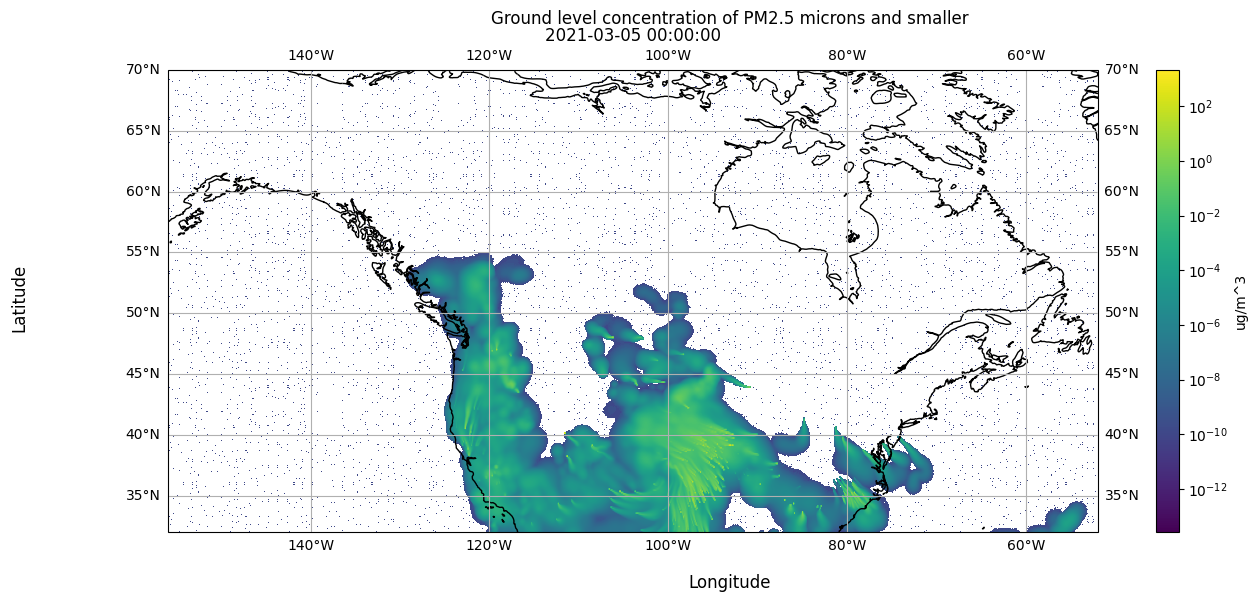

In [12]:
tstep = 15 # <1>
smoke_at_tstep = ds_pm25_vals[tstep, :, :] # <2>
tstep_tflag = parse_tflag(ds['TFLAG'].values[tstep][0]) # <3>

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

my_fig, my_plt = plt.subplots(figsize=(15, 6), subplot_kw=dict(projection=ccrs.PlateCarree())) # <4>

my_norm = "log" # <5>
my_extent = [np.min(longitude), np.max(longitude), np.min(latitude), np.max(latitude)] # <6>
my_aspect = 'auto' # <7>
my_origin = 'lower' # <8>
my_cmap = 'viridis' # <9>

plot = my_plt.imshow(smoke_at_tstep, norm=my_norm, extent=my_extent, 
          aspect=my_aspect, origin=my_origin, cmap=my_cmap) # <10>

my_plt.coastlines() # <11>

my_plt.gridlines(draw_labels=True) # <12>

my_fig.colorbar(plot, location='right', label='ug/m^3') # <13>

my_fig.supxlabel('Longitude') # <14>
my_fig.supylabel('Latitude') # <15>

my_fig.suptitle('Ground level concentration of PM2.5 microns and smaller') # <16>

my_plt.set_title(f'{tstep_tflag}') # <17>

plt.show() # <18>

1. Define the time step.
2. Extract the PM2.5 data for the specified time step.
3. Parse the time flag for the specified time step.
4. Initialize a figure and plot with a specific projection.
5. Set the normalization for PM2.5 values to a logarithmic scale.
6. Define the extent of the plot based on the longitude and latitude range.
7. Set the aspect ratio of the plot to fit all data automatically.
8. Specify the origin of the plot as the lower-left corner.
9. Choose a colormap for the plot.
10. Create the plot using `imshow` with the specified parameters.
11. Draw coastlines on the plot.
12. Draw latitude and longitude lines with labels.
13. Add a colorbar to the figure based on the plot.
14. Set the x-axis label.
15. Set the y-axis label.
16. Set the title of the figure.
17. Set the title of the plot as the timestamp of the data.
18. Display the resulting visualization.

In [13]:
ds.close()